In [1]:
import pandas as pd
import numpy as np
import math as mt

import tensorflow as tf
from tensorflow.python.framework import ops

#from gplearn.genetic import SymbolicRegressor

from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost
#import os
#import re

#from scipy.optimize import minimize

#from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
#from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
#from sklearn.svm import LinearSVC, SVC
#from sklearn.linear_model import LogisticRegression, RidgeClassifier
#from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, LabelBinarizer
#from sklearn.decomposition import PCA

#os.environ['PATH'] = 'c:\Program Files\VowpalWabbit\;' + os.environ['PATH']

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load House train data
train = pd.read_csv('train.csv')

In [3]:
# Put the labels aside
labels_orig = train.SalePrice.as_matrix().reshape(-1, 1)

In [4]:
# Which columns have NaN values?
count = 0

for col in train.columns:
    if(train[col].isnull().sum() > 0):
        print(col)
        count = count + 1
        
print("Total", count, "columns with NaNs")

LotFrontage
Alley
MasVnrType
MasVnrArea
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Electrical
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageQual
GarageCond
PoolQC
Fence
MiscFeature
Total 19 columns with NaNs


In [5]:
# Define variables
cols = []

In [6]:
train.iloc[:, :9].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl


In [7]:
# MSSubClass
enc = OneHotEncoder(sparse=False)
cols.append(enc.fit_transform(train.MSSubClass.values.reshape(-1, 1)))

In [8]:
# MSZoning
cols.append(pd.get_dummies(train.MSZoning).as_matrix())

In [9]:
# LotFrontage
train.LotFrontage.fillna(0.0, inplace=True)
cols.append(train.LotFrontage.as_matrix().reshape(-1, 1))

In [10]:
# LotArea
cols.append(train.LotArea.as_matrix().reshape(-1, 1))

In [11]:
# Street
cols.append(pd.get_dummies(train.Street).as_matrix())

In [12]:
# Alley
train.Alley.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.Alley).as_matrix())

In [13]:
# LotShape
cols.append(pd.get_dummies(train.LotShape).as_matrix())

In [14]:
# LandContour
cols.append(pd.get_dummies(train.LandContour).as_matrix())

In [15]:
# Utilities
cols.append(pd.get_dummies(train.Utilities).as_matrix())

In [16]:
train.iloc[:, 9:19].head()

,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond
0,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5
1,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8
2,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5
3,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5
4,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5


In [17]:
# LotConfig
cols.append(pd.get_dummies(train.LotConfig).as_matrix())

In [18]:
# LandSlope
cols.append(pd.get_dummies(train.LandSlope).as_matrix())

In [19]:
# Neighborhood 
cols.append(pd.get_dummies(train.Neighborhood).as_matrix())

In [20]:
# Condition1
cols.append(pd.get_dummies(train.Condition1).as_matrix())

In [21]:
# Condition2
cols.append(pd.get_dummies(train.Condition2).as_matrix())

In [22]:
# BldgType
cols.append(pd.get_dummies(train.BldgType).as_matrix())

In [23]:
# HouseStyle
cols.append(pd.get_dummies(train.HouseStyle).as_matrix())

In [24]:
# OverallQual
enc = OneHotEncoder(sparse=False)
cols.append(enc.fit_transform(train.OverallQual.values.reshape(-1, 1)))

In [25]:
# OverallCond
enc = OneHotEncoder(sparse=False)
cols.append(enc.fit_transform(train.OverallCond.values.reshape(-1, 1)))

In [26]:
train.iloc[:, 19:29].head()

,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond
0,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA
1,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA
2,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA
3,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA
4,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA


In [27]:
# YearBuilt
# Keep it continuous for the first round
cols.append(train.YearBuilt.as_matrix().reshape(-1, 1))

In [28]:
# YearRemodAdd
# Keep it continuous for the first round
cols.append(train.YearRemodAdd.as_matrix().reshape(-1, 1))

In [29]:
# RoofStyle
cols.append(pd.get_dummies(train.RoofStyle).as_matrix())

In [30]:
# RoofMatl
cols.append(pd.get_dummies(train.RoofMatl).as_matrix())

In [31]:
# Exterior1st
cols.append(pd.get_dummies(train.Exterior1st).as_matrix())

In [32]:
# Exterior2nd
cols.append(pd.get_dummies(train.Exterior2nd).as_matrix())

In [33]:
# MasVnrType
train.MasVnrType.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.MasVnrType).as_matrix())

In [34]:
# MasVnrArea
train.MasVnrArea.fillna(0.0, inplace=True)
cols.append(pd.get_dummies(train.MasVnrArea).as_matrix())

In [35]:
# ExterQual
cols.append(pd.get_dummies(train.ExterQual).as_matrix())

In [36]:
# ExterCond
cols.append(pd.get_dummies(train.ExterCond).as_matrix())

In [37]:
train.iloc[:, 29:39].head()

,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
0,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856
1,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262
2,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920
3,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756
4,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145


In [38]:
# Foundation
cols.append(pd.get_dummies(train.Foundation).as_matrix())

In [39]:
# BsmtQual
train.BsmtQual.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.BsmtQual).as_matrix())

In [40]:
# BsmtCond
train.BsmtCond.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.BsmtCond).as_matrix())

In [41]:
# BsmtExposure
train.BsmtExposure.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.BsmtExposure).as_matrix())

In [42]:
# BsmtFinType1
train.BsmtFinType1.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.BsmtFinType1).as_matrix())

In [43]:
# BsmtFinSF1
# Keep it continuous for the first round
cols.append(train.BsmtFinSF1.as_matrix().reshape(-1, 1))

In [44]:
# BsmtFinType2
train.BsmtFinType2.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.BsmtFinType2).as_matrix())

In [45]:
# BsmtFinSF2
# Keep it continuous for the first round
cols.append(train.BsmtFinSF2.as_matrix().reshape(-1, 1))

In [46]:
# BsmtUnfSF
# Keep it continuous for the first round
cols.append(train.BsmtUnfSF.as_matrix().reshape(-1, 1))

In [47]:
# TotalBsmtSF
# Keep it continuous for the first round
cols.append(train.TotalBsmtSF.as_matrix().reshape(-1, 1))

In [48]:
train.iloc[:, 39:49].head()

,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath
0,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0
1,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1
2,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0
3,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0
4,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0


In [49]:
# Heating
cols.append(pd.get_dummies(train.Heating).as_matrix())

In [50]:
# HeatingQC
cols.append(pd.get_dummies(train.HeatingQC).as_matrix())

In [51]:
# CentralAir
cols.append(pd.get_dummies(train.CentralAir).as_matrix())

In [52]:
# Electrical
train.Electrical.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.Electrical).as_matrix())

In [53]:
# 1stFlrSF
cols.append(train['1stFlrSF'].as_matrix().reshape(-1, 1))

In [54]:
# 2ndFlrSF
cols.append(train['2ndFlrSF'].as_matrix().reshape(-1, 1))

In [55]:
# LowQualFinSF
cols.append(train.LowQualFinSF.as_matrix().reshape(-1, 1))

In [56]:
# GrLivArea
cols.append(train.GrLivArea.as_matrix().reshape(-1, 1))

In [57]:
# BsmtFullBath
cols.append(train.BsmtFullBath.as_matrix().reshape(-1, 1))

In [58]:
# BsmtHalfBath
cols.append(train.BsmtHalfBath.as_matrix().reshape(-1, 1))

In [59]:
train.iloc[:, 49:59].head()

,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType
0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd
1,2,0,3,1,TA,6,Typ,1,TA,Attchd
2,2,1,3,1,Gd,6,Typ,1,TA,Attchd
3,1,0,3,1,Gd,7,Typ,1,Gd,Detchd
4,2,1,4,1,Gd,9,Typ,1,TA,Attchd


In [60]:
# FullBath
cols.append(train.FullBath.as_matrix().reshape(-1, 1))

In [61]:
# HalfBath
cols.append(train.HalfBath.as_matrix().reshape(-1, 1))

In [62]:
# BedroomAbvGr
cols.append(train.BedroomAbvGr.as_matrix().reshape(-1, 1))

In [63]:
# KitchenAbvGr
cols.append(train.KitchenAbvGr.as_matrix().reshape(-1, 1))

In [64]:
# KitchenQual
cols.append(pd.get_dummies(train.KitchenQual).as_matrix())

In [65]:
# TotRmsAbvGrd
cols.append(train.TotRmsAbvGrd.as_matrix().reshape(-1, 1))

In [66]:
# Functional
cols.append(pd.get_dummies(train.Functional).as_matrix())

In [67]:
# Fireplaces
cols.append(train.Fireplaces.as_matrix().reshape(-1, 1))

In [68]:
# FireplaceQu
train.FireplaceQu.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.FireplaceQu).as_matrix())

In [69]:
# GarageType
train.GarageType.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.GarageType).as_matrix())

In [70]:
train.iloc[:, 59:69].head()

,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch
0,2003.0,RFn,2,548,TA,TA,Y,0,61,0
1,1976.0,RFn,2,460,TA,TA,Y,298,0,0
2,2001.0,RFn,2,608,TA,TA,Y,0,42,0
3,1998.0,Unf,3,642,TA,TA,Y,0,35,272
4,2000.0,RFn,3,836,TA,TA,Y,192,84,0


In [71]:
# GarageYrBlt
train.GarageYrBlt.fillna(0.0, inplace=True)
cols.append(train.GarageYrBlt.as_matrix().reshape(-1, 1))

In [72]:
# GarageFinish
train.GarageFinish.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.GarageFinish).as_matrix())

In [73]:
# GarageCars
cols.append(train.GarageCars.as_matrix().reshape(-1, 1))

In [74]:
# GarageArea
cols.append(train.GarageArea.as_matrix().reshape(-1, 1))

In [75]:
# GarageQual
train.GarageQual.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.GarageQual).as_matrix())

In [76]:
# GarageCond
train.GarageCond.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.GarageCond).as_matrix())

In [77]:
# PavedDrive
cols.append(pd.get_dummies(train.PavedDrive).as_matrix())

In [78]:
# WoodDeckSF
cols.append(train.WoodDeckSF.as_matrix().reshape(-1, 1))

In [79]:
# OpenPorchSF
cols.append(train.OpenPorchSF.as_matrix().reshape(-1, 1))

In [80]:
# EnclosedPorch
cols.append(train.EnclosedPorch.as_matrix().reshape(-1, 1))

In [81]:
train.iloc[:, 69:].head()

,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [82]:
# 3SsnPorch
cols.append(train['3SsnPorch'].as_matrix().reshape(-1, 1))

In [83]:
# ScreenPorch
cols.append(train.ScreenPorch.as_matrix().reshape(-1, 1))

In [84]:
# PoolArea
cols.append(train.PoolArea.as_matrix().reshape(-1, 1))

In [85]:
# PoolQC
train.PoolQC.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.PoolQC).as_matrix())

In [86]:
# Fence
train.Fence.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.Fence).as_matrix())

In [87]:
# MiscFeature
train.MiscFeature.fillna("Unknown", inplace=True)
cols.append(pd.get_dummies(train.MiscFeature).as_matrix())

In [88]:
# MiscVal
cols.append(train.MiscVal.as_matrix().reshape(-1, 1))

In [89]:
# MoSold
cols.append(pd.get_dummies(train.MoSold).as_matrix())

In [90]:
# YrSold
cols.append(pd.get_dummies(train.YrSold).as_matrix())

In [91]:
# SaleType
cols.append(pd.get_dummies(train.SaleType).as_matrix())

In [92]:
# SaleCondition
cols.append(pd.get_dummies(train.SaleCondition).as_matrix())

In [93]:
# Combine all columns-matrices together
features = numpy.concatenate(cols, axis=1)
labels = train.SalePrice.values.reshape(-1, 1)

In [94]:
#
# Scaling
#
# First scale labels
labels = labels.astype(float)
labels_max = labels.max()

labels = labels / labels_max

# Now scale features
#for ii in range(features.shape[0]):
#    if((features[ii, :] > 25.).sum() > 0):
#        mx = float(features[ii, :].max())

#        features[ii, :] = features[ii, :] / mx
     
count = 0
    
for jj in range(features.shape[1]):
    if((features[:, jj] > 25.).sum() > 0):
        mx = float(features[:, jj].max())

        features[:, jj] = features[:, jj] / mx
        count = count + 1
        
print("Total", count, "features scaled")

Total 21 features scaled


In [95]:
# Split for train and test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=23)

In [96]:
print(features_train.shape)
print(labels_train.shape)

(1022, 676)
(1022, 1)


### Baseline

C "неправильным scaling по строкам перебор параметров закончился так:  
-0.027645944962  
{'min_samples_split': 6, 'n_estimators': 250, 'min_samples_leaf': 2}  

А с маштабированием по столбцам, что вроде более правильно, получается так:  
-0.0233410060557  
{'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}  

Итоговое значение baseline:  
#### 0.0210354478273

### Gradient Boosting

In [98]:
%%time
GBR = GradientBoostingRegressor(random_state=23)

parameters_grid = {
    "n_estimators": [100, 150, 200, 250, 300],
    #"learning_rate ": [0.1, 0.05, 0.01, 0.005, 0.001],
    "min_samples_split": [2, 3, 4, 5, 6],
    "min_samples_leaf": [1, 2, 3, 4]
}

gcv = GridSearchCV(GBR, parameters_grid, scoring='neg_mean_absolute_error')

gcv.fit(features_train, labels_train.reshape(-1))

print(gcv.best_score_)
print(gcv.best_params_)

-0.0233410060557
{'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Wall time: 8min 2s


In [255]:
GBR = GradientBoostingRegressor(n_estimators=300, min_samples_split=5, min_samples_leaf=2, random_state=23)
GBR.fit(features_train, labels_train.reshape(-1))

GBR_prediction = GBR.predict(features_test)

print(mean_absolute_error(labels_test, GBR_prediction))

0.0210354478273


### Random Forest

In [243]:
%%time
RFR = RandomForestRegressor(n_jobs=-1, random_state=23)

parameters_grid = {
    "n_estimators": [50, 100, 150, 200, 250, 300],
    "min_samples_split": [2, 3, 4, 5, 6],
    "min_samples_leaf": [1, 2, 3, 4]
}

gcv = GridSearchCV(RFR, parameters_grid, scoring='neg_mean_absolute_error')

gcv.fit(features_train, labels_train.reshape(-1))

print(gcv.best_score_)
print(gcv.best_params_)

-0.0248013287264
{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Wall time: 8min 43s


In [256]:
RFR = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1, n_jobs=-1, random_state=23)
#RFR = gcv.best_estimator_ 
RFR.fit(features_train, labels_train.reshape(-1))

RFR_prediction = RFR.predict(features_test)

print(mean_absolute_error(labels_test, RFR_prediction))

0.0238355953798


### XGBoost

In [250]:
%%time
XGB = xgboost.XGBRegressor()

parameters_grid = {
    #"n_estimators": [50, 100, 150, 200, 250, 300],
    "n_estimators": [250, 300, 350],
    #"max_depth": [2, 3, 4, 5, 6, 7, 8],
    "max_depth": [3, 4],
    #"learning_rate": [0.1, 0.05, 0.01]
    "learning_rate": [0.1],
}

gcv = GridSearchCV(XGB, parameters_grid, scoring='neg_mean_absolute_error')

gcv.fit(features_train, labels_train.reshape(-1))

print(gcv.best_score_)
print(gcv.best_params_)

-0.0230161950111
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 350}
Wall time: 1min 22s


In [257]:
XGB = xgboost.XGBRegressor(max_depth=3, n_estimators=350)
#XGB = gcv.best_estimator_
XGB.fit(features_train, labels_train.reshape(-1))

XGB_prediction = XGB.predict(features_test)

print(mean_absolute_error(labels_test, XGB_prediction))

0.0208183045147


In [258]:
avg_prediction = (GBR_prediction + RFR_prediction + XGB_prediction) / 3.0

print(mean_absolute_error(labels_test, avg_prediction))

0.021131190807


### Neural Network

In [97]:
# Transpose to have the shape of (num_of_features, num_of_examples)
features_train = features_train.T
labels_train = labels_train.T
features_test = features_test.T
labels_test = labels_test.T

In [98]:
# Helper functions
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of a input data vector 
    n_y -- scalar, size of output data
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    """

    X = tf.placeholder(tf.float32, shape=(n_x, None), name = "X")
    Y = tf.placeholder(tf.float32, shape=(n_y, None), name = "Y")
    LR = tf.placeholder(tf.float32, name = "LR")
    
    return X, Y, LR

In [99]:
# Helper functions
def forward_propagation(X, parameters, keep_prob):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> etc.
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # The model
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              
    A1 = tf.nn.dropout(tf.nn.relu(Z1), keep_prob)
    #A1 = tf.nn.relu(Z1)
    
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                              
    A2 = tf.nn.dropout(tf.nn.relu(Z2), keep_prob)
    #A2 = tf.nn.relu(Z2)
    
    Z3 = tf.add(tf.matmul(W3, A2), b3)

    return Z3

In [100]:
# Helper functions
def compute_cost(Yhat, Y, parameters, lambd=0.0):
    """
    Computes the cost
    
    Arguments:
    Yhat -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    
    cost = tf.reduce_mean(
        tf.nn.l2_loss(Yhat - Y) +
        lambd*tf.nn.l2_loss(W1) + lambd*tf.nn.l2_loss(W2) + 
        lambd*tf.nn.l2_loss(W3))
    
    return cost

In [119]:
# Helper functions

In [120]:
# Helper functions

In [121]:
# Helper functions

In [101]:
# Helper functions
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.001, lambd=0.0, keep_prob=1.0,
          num_epochs=1000, minibatch_size=64, print_cost=True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    lambd -- regularization parameter
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # To keep track of MAE on test set
    test_mae = [] 
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y, LR = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    last_activation = forward_propagation(X, parameters, keep_prob)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(last_activation, Y, parameters, lambd)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=LR).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for iteration in range(num_epochs):
            
            # Floating learning rate
            #if ((iteration > 0) and (iteration % 5000 == 0)):
            #    learning_rate = learning_rate / 1.5

            # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
            _ , iteration_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train, LR: learning_rate})
                
            # Print the cost 
            #print(iteration_cost)
            
            if (iteration % 1000 == 0):
                print ("Cost at iteration %i: %f" % (iteration, iteration_cost))
            if (iteration % 25 == 0):
                costs.append(iteration_cost)
                
                # Compute MAE on test set
                yhat, _ = sess.run([last_activation, cost], feed_dict={X: X_test, Y: Y_test, LR: learning_rate})
                mae = mean_absolute_error(Y_test.T, yhat.T)
                test_mae.append(mae)
                
        # Results Visualization
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

        # plot the cost
        plt.subplot(1, 2, 1)
        plt.plot(costs, 'b-')
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))

        # plot MAE on test set
        plt.subplot(1, 2, 2)
        plt.plot(test_mae, 'r-')
        plt.ylabel('Mean Absolute Error')
        plt.xlabel('Iterations')
        plt.title("Mean Absolute Error on Test Data")

        plt.show()  

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        #correct_prediction = tf.equal(tf.argmax(tf.nn.sigmoid(Z3)), tf.argmax(Y))
        
        # Accuracy on train data
        #yhat = tf.nn.sigmoid(Z3)
        #prediction = sess.run([yhat], feed_dict={X: X_train, Y: Y_train})
        
        #print("Accuracy on train data:", accuracy_score(Y_train.reshape(-1), np.round(prediction[0]).reshape(-1)))
        print("Final loss on train data:", iteration_cost)
        print("Minimum MAE on test data:", np.min(test_mae))
        print("Final MAE on test data:", test_mae[-1])
        
        # Accuracy on test data
        yhat, test_cost = sess.run([last_activation, cost], feed_dict={X: X_test, Y: Y_test, LR: learning_rate})
        print("Loss on test data:", test_cost)
        
        #print("Accuracy on test data:", accuracy_score(Y_test.reshape(-1), np.round(prediction[0]).reshape(-1)))
        

        # Calculate accuracy on the test set
        #accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        #print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        #print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        #yhat = sess.run([Z3], feed_dict={X: X_train, Y: Y_train})
        return parameters, yhat

In [102]:
# Helper functions
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. 
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(23)                   
        
    W1 = tf.get_variable("W1", [128, 676], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [128, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [128, 128], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [128, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [1, 128], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [1, 1], initializer = tf.zeros_initializer())


    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

Cost at iteration 0: 89.422501
Cost at iteration 1000: 0.761585
Cost at iteration 2000: 0.405243
Cost at iteration 3000: 0.249239
Cost at iteration 4000: 0.188481


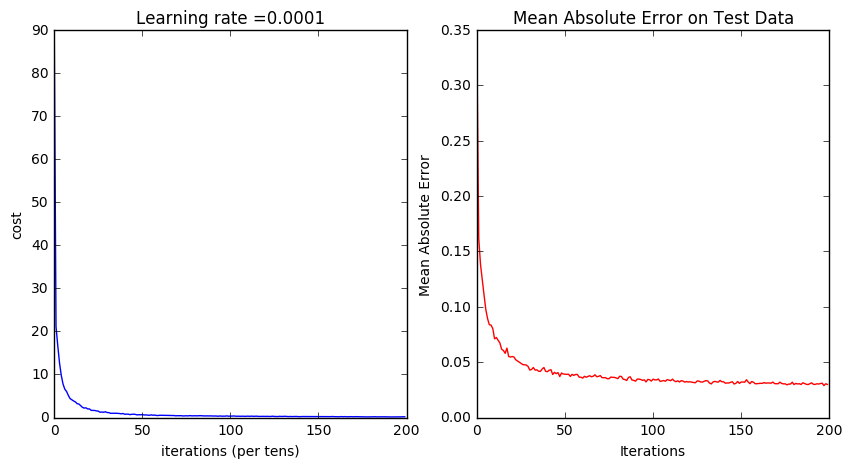

Parameters have been trained!
Final loss on train data: 0.119469
Minimum MAE on test data: 0.0288137874157
Final MAE on test data: 0.0298820546163
Loss on test data: 0.393688
Wall time: 2min 38s


In [103]:
%%time
#parameters, prediction = model(features_train, labels_train, features_test, labels_test, learning_rate=0.001, num_epochs=6000)
parameters, prediction = model(features_train, labels_train, features_test, labels_test, learning_rate=0.0001, keep_prob=0.9, num_epochs=5000)

In [130]:
print(mean_absolute_error(labels_test.T, prediction.T))

0.0253713681035


Cost at iteration 0: 247.631973
Cost at iteration 1000: 32.562012
Cost at iteration 2000: 12.889617
Cost at iteration 3000: 6.073007
Cost at iteration 4000: 2.980466
Cost at iteration 5000: 1.644153
Cost at iteration 6000: 1.152715
Cost at iteration 7000: 1.005533
Cost at iteration 8000: 0.961800
Cost at iteration 9000: 0.943203


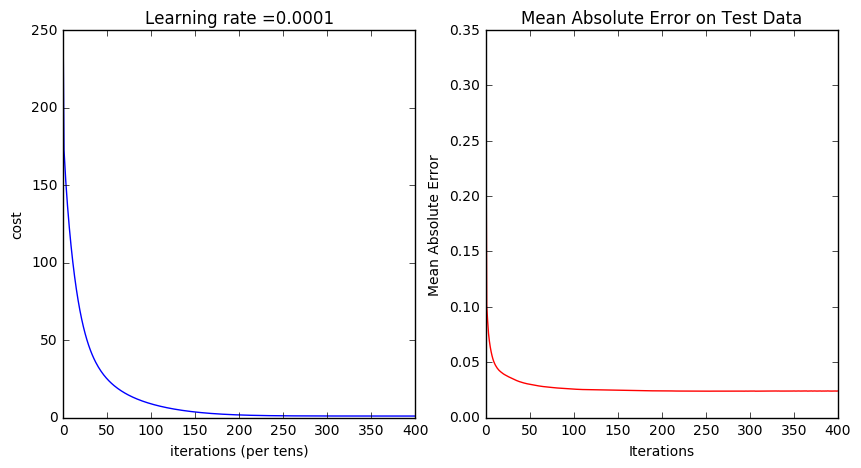

Parameters have been trained!
Final loss on train data: 0.935247
Minimum MAE on test data: 0.0237491920404
Final MAE on test data: 0.0239372634086
Loss on test data: 0.968144
Wall time: 4min 24s


In [114]:
%%time
parameters, prediction = model(features_train, labels_train, features_test, labels_test, learning_rate=0.0001, lambd=1.0, num_epochs=10000)
#parameters, prediction = model(features_train, labels_train, features_test, labels_test, learning_rate=0.0001, lambd=0.00001, num_epochs=30000)

Cost at iteration 0: 26.388094
Cost at iteration 1000: 0.792221
Cost at iteration 2000: 0.443219
Cost at iteration 3000: 0.335998
Cost at iteration 4000: 0.254119
Cost at iteration 5000: 0.163990
Cost at iteration 6000: 0.169059
Cost at iteration 7000: 0.165216
Cost at iteration 8000: 0.127453
Cost at iteration 9000: 0.126100
Cost at iteration 10000: 0.151108
Cost at iteration 11000: 0.170127
Cost at iteration 12000: 0.100209
Cost at iteration 13000: 0.116568
Cost at iteration 14000: 0.127669
Cost at iteration 15000: 0.118478
Cost at iteration 16000: 0.121763
Cost at iteration 17000: 0.124968
Cost at iteration 18000: 0.105371
Cost at iteration 19000: 0.096445
Cost at iteration 20000: 0.082409
Cost at iteration 21000: 0.133226
Cost at iteration 22000: 0.128450
Cost at iteration 23000: 0.091469
Cost at iteration 24000: 0.128655
Cost at iteration 25000: 0.099019
Cost at iteration 26000: 0.087220
Cost at iteration 27000: 0.100083
Cost at iteration 28000: 0.098343
Cost at iteration 29000: 0

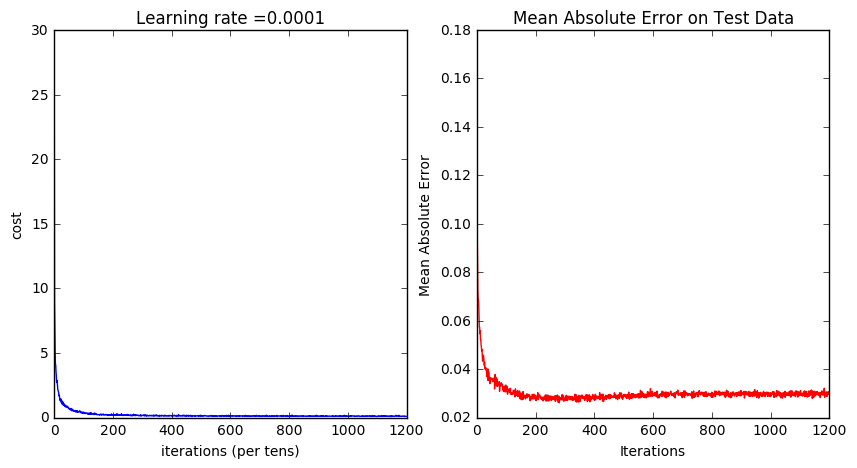

Parameters have been trained!
Final loss on train data: 0.091203
Minimum MAE on test data: 0.026043970016
Final MAE on test data: 0.0298247721845
Loss on test data: 0.437494
Wall time: 13min 40s


In [119]:
%%time
parameters, prediction = model(features_train, labels_train, features_test, labels_test, learning_rate=0.0001, keep_prob=0.9, num_epochs=30000)

Cost at iteration 0: 45.133015
Cost at iteration 1000: 1.762749
Cost at iteration 2000: 0.915429
Cost at iteration 3000: 0.641733
Cost at iteration 4000: 0.486918
Cost at iteration 5000: 0.427491
Cost at iteration 6000: 0.389210
Cost at iteration 7000: 0.391227
Cost at iteration 8000: 0.331236
Cost at iteration 9000: 0.346398
Cost at iteration 10000: 0.300632
Cost at iteration 11000: 0.369913
Cost at iteration 12000: 0.298553
Cost at iteration 13000: 0.272920
Cost at iteration 14000: 0.235711
Cost at iteration 15000: 0.265265
Cost at iteration 16000: 0.238271
Cost at iteration 17000: 0.215761
Cost at iteration 18000: 0.261030
Cost at iteration 19000: 0.208971
Cost at iteration 20000: 0.210864
Cost at iteration 21000: 0.244673
Cost at iteration 22000: 0.215305
Cost at iteration 23000: 0.265650
Cost at iteration 24000: 0.223003
Cost at iteration 25000: 0.221026
Cost at iteration 26000: 0.223159
Cost at iteration 27000: 0.300667
Cost at iteration 28000: 0.244310
Cost at iteration 29000: 0

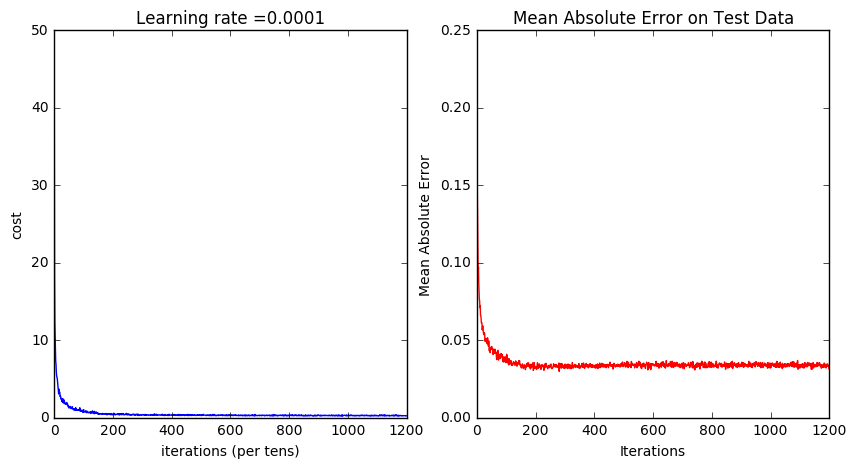

Parameters have been trained!
Final loss on train data: 0.245551
Minimum MAE on test data: 0.0297756180267
Final MAE on test data: 0.0313526047671
Loss on test data: 0.572326
Wall time: 13min 42s


In [120]:
%%time
parameters, prediction = model(features_train, labels_train, features_test, labels_test, learning_rate=0.0001, keep_prob=0.8, num_epochs=30000)

In [1242]:
(prediction * labels_max).reshape(-1)[:20]

array([ 163840.75     ,  170094.546875 ,  163416.640625 ,  111271.9609375,
        151992.046875 ,  218355.8125   ,   99572.6875   ,  386877.8125   ,
        152057.734375 ,  364481.5625   ,  162330.046875 ,  283493.375    ,
        295168.5625   ,  149298.546875 ,  111930.546875 ,  137187.53125  ,
        139007.5      ,  154961.375    ,   92957.28125  ,   93675.3203125], dtype=float32)

In [1243]:
(labels_test * labels_max).reshape(-1)[:20]

array([ 186000.,  214500.,  177000.,  185000.,   60000.,  223500.,
         64500.,  437154.,  135000.,  440000.,  182900.,  207500.,
        257500.,  164500.,  121000.,   34900.,  145000.,  175000.,
         79900.,  118500.])

In [1260]:
print(mean_absolute_error(labels_test, prediction))

0.0274287305966


In [ ]:
#
# Helpers
#
def write_to_submission_file(predicted_labels, passenger_ids, out_file="submission.csv",
                             target='Survived', index_label="PassengerId"):
    
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = passenger_ids,
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)